04.03.2021

uses A07tv instead of A06tv: for the classification timeline use the index not the filename.

Because with the index, data is numerical and we can use an numpy array and do not need pandas.

To get the information on the filenames we will have to run through the validation set once more, in an additional for loop.

to dos:
* finalize visualization for classification timeline: coloured backgrounds in red or green according to error or correct classification at final epoch? Run ctl only till the chosen epoch when the model was saved? Do it not in the mean for the repetitions, but for a fixed model. 
* Compare oscillation / confidence in classification between different architectures.
* compare confidence with accuracy: When confident, is the classification (mostly) correct? When not confident, is the classification mostly incorrect? 
* Compare: Oscillation for different ethniities or (gender, ethnicity) combinations.

dones:
* Visualise: Show oscillation and Image side by side for images with correct classification vs misclassification.
* change documentation of ctl prom dict and pandas to numpy in A07tv.py
* visualize oscillation of classification for validation images , for all the independent repetitions in a single plot
* small multiple of oscillations for 20 validation images
* boxplots for variation of oscillation in the independent repetitions (repeated training and validation loops over full num_episodes: clearly not random. Result: Oscillation in classification can be used as an indicator on how confident the algorithm is about the classification.

In [1]:
!pwd

/home/jovyan/LFI/bainbridge_2k/code


In [43]:
main_dir = '/home/jovyan/LFI/bainbridge_2k/'

# location of original labels: LFI/bainbridge_2k/meta
label_file = '../meta/labels2k_A_train.csv'

images_train_dir = '../images_train/'
images_test_dir = '../images_test/'

!ls $images_train_dir | wc -l 
!ls $images_test_dir | wc -l # both numbers should add to 2222 - 14 (doublettes) = 2208

# to build PATH to save the best model
model_dir = 'myModels/best/'

docume_dir = 'myModels/documentation-C/' # base directory, will get a subdir matching the model ( model.get_name() )

2108
100


In [44]:
'''# not necessary to run this - these requirements are already satisfied
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install torch
!pip install torchvision'''

'# not necessary to run this - these requirements are already satisfied\n!pip install numpy\n!pip install pandas\n!pip install matplotlib\n!pip install torch\n!pip install torchvision'

In [45]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

import torchvision
from torchvision import transforms, utils

import PIL

In [46]:
# plt.rcParams['figure.figsize'] = (10, 5)

In [47]:
def set_all_seeds(s): 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(s)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(s)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(s)

    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(s)

# define the model

In [48]:
from myModels import myModels as mm # mm = myModels
!pip install pytorch_model_summary
import pytorch_model_summary as pms

In [49]:
model = mm.MyNeuralNetwork3()

imgH, imgW = model.get_img_shape() # get the required image size for the model
# to be used in the transform of the Dataset

# order of imgH, imgW might be off. I have quadratic images so I don't care
print(pms.summary(model, torch.zeros((1, 3, imgH, imgW)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 64, 64]             112             112
       MaxPool2d-2      [1, 4, 64, 64]               0               0
       Dropout2d-3      [1, 4, 31, 31]               0               0
          Linear-4           [1, 3844]           7,690           7,690
          Linear-5              [1, 2]               6               6
Total params: 7,808
Trainable params: 7,808
Non-trainable params: 0
-----------------------------------------------------------------------


In [9]:
docume_dir_named = docume_dir+model.get_model_name()+'/'
print(model.get_model_name())
!ls $docume_dir

MyNeuralNetwork3
MyNeuralNetwork3


if the directory already exist, it cannot be overwritten.

move the existing folder to a new name.

In [10]:
!mkdir $docume_dir_named

mkdir: cannot create directory ‘myModels/documentation-C/MyNeuralNetwork3/’: File exists


# Dataset and DataLoader for training (and val) set(s)

In [50]:
import A07tv as tv # train validate

In [51]:
df = pd.read_csv(label_file, index_col=0) 
df.index=range(df.shape[0])
setup = df[['Gender','Age','Race','newFilename']].copy()

# transform , no normalizing
transform = transforms.Compose([
    transforms.Resize((imgH,imgW)), # imgH, imgW as required for model
    transforms.ToTensor()
])

trainset = tv.TrainSet(setup=setup , transform=transform)

train_loader, val_loader = tv.loaders(trainset, setup) # batch_size=10, split=100 as defaults

In [52]:
len(val_loader.dataset) , len(train_loader.dataset)

(100, 2008)

## Train and validate

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("torch.cuda.is_available(): ", torch.cuda.is_available())

torch.cuda.is_available():  True


In [54]:
from copy import deepcopy

## model setup
# variable model holds the model defined in first paragraph.
model = model.to(device) # pushing to device before passing it ti training() and validate() functions

learning_rate = 0.001
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

print('**', model)

num_epochs = 50 # 150 when things run smoothly
C=2 # number of classes
T=5 # loops for statistical evaluation

# ctl : classification timeline
# only 1 epoch, not a timeline really
ctl_epoch = np.zeros((len(val_loader.dataset),2), dtype=np.int16) # 2 for index and prediction
# a real timeline
ctl = np.zeros((*ctl_epoch.shape, num_epochs), dtype=np.int16) # added dimension for each epoch
# independent repetitions of training and validation loops , a timeline for each repetition
docume_ctl = np.zeros((T,*ctl.shape), dtype=np.int16) 

docume_error = np.zeros((T,C,num_epochs), dtype=np.int8)
docume_tvla = np.zeros((T,4,num_epochs))
docume_ge = np.zeros((T,2,7,C,num_epochs), dtype=np.int8) # 2: 0,1 pred, label different or not, 7: number of ethnicities
docume_f1 = np.zeros((T,num_epochs))

#good_seeds = [1,2,3,8,11,12] # for model 3 it happens that the model does not learn.
# we avoid these (bad) seeds.

for t in range(T):
    print('Repetition {}/{}'.format(t, T - 1))
    print('+' * 20)
    
    best_acc = 0.0
    #stop_epoch = 0

    #seed_value = good_seeds[t]
    seed_value = t 
    set_all_seeds(seed_value)
    
    for name, module in model.named_children():
        if hasattr(module, 'reset_parameters'):
            #print('resetting ', name)
            module.reset_parameters()
    
    train_acc_history = []
    val_acc_history = []

    train_loss_history = []
    val_loss_history = []

    val_fn_history = []
    val_fp_history = []
    
    f1_history =[]

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # train
        training_loss, training_acc = tv.training(model, train_loader, optimizer, criterion, device)
        train_loss_history.append(training_loss)
        train_acc_history.append(training_acc)

        # validation
        val_loss , val_cf_m , ctl_epoch, g_by_e, f1 = tv.validate(model, val_loader, criterion, device)
        # print('received from tv.validate : ' , ctl_epoch)
    
        if epoch==0:         
            g_by_e_hist = g_by_e[:,:,:].reshape((2,7,C,1))
            #print('epoch 0, g_by_e_hist :\n' , g_by_e_hist)
        else:
            g_by_e = g_by_e[:,:,:].reshape((2,7,2,1))
            g_by_e_hist = np.concatenate((g_by_e_hist, g_by_e), axis=3)
        
        val_loss_history.append(val_loss)
        
        tn, fp, fn, tp = val_cf_m.ravel()
        val_acc = (tp+tn)/len(val_loader.dataset)
        val_acc_history.append(val_acc)
       
        val_fn_history.append(fn)
        val_fp_history.append(fp)
        
        f1_history.append(f1)

        ctl[:,:,epoch]= ctl_epoch 
        
        # overall best model
        if val_acc > best_acc:
            best_acc = val_acc
          #  stop_epoch = epoch
           # best_model_wts = deepcopy(model.state_dict())
            # docume_best_model just for surveillance. We only need best_model_wts
            # best_model_wts has length of 10, so I put it in a list. 
            # to extract it, use docume_best_model['state_dict'][0]
            # docume_best_model = docume_best_model.append(pd.DataFrame({'t':t,'epoch':epoch,'val acc':val_acc,'state_dict':[best_model_wts]}), ignore_index=True)
          
        ## end of train val epoch , go up to loop again or
    ## finish the train val epochs
    ## and document
        
    docume_error[t,0,:] = val_fn_history
    docume_error[t,1,:] = val_fp_history 
    
    docume_tvla[t,0,:] = train_loss_history # training, validation, loss and accuracy
    docume_tvla[t,1,:] = val_loss_history
    docume_tvla[t,2,:] = train_acc_history
    docume_tvla[t,3,:] = val_acc_history
    
    docume_ge[t,:,:,:] = g_by_e_hist
    
    docume_ctl[t:,:,:] = ctl
    
    docume_f1[t,:] = f1_history
    
    print(f'Best acc in validation: {best_acc:4f}')

    # We don't need the best model, do we?!
    # save the best model for final evaluation on test data
    #PATH = model_dir+'{}_acc{}_epoch{}.pt'.format(model.get_model_name(), int(10000*best_acc), stop_epoch)
    #torch.save(best_model_wts, PATH )

** MyNeuralNetwork3(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3844, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=2, bias=True)
)
Repetition 0/4
++++++++++++++++++++
Epoch 0/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.6889 Acc: 0.5657

Validation Batch:    0 of 10
----------
validation Loss: 0.6852 Acc: 0.5700

Epoch 1/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.6837 Acc: 0.5722

Validation Batch:    0 of 10
----------
validation Loss: 0.6836 Acc: 0.5700

Epoch 2/49
----------
Training Batch:    0 o

Training Batch:  200 of 201
----------
Training Loss: 0.6829 Acc: 0.5722

Validation Batch:    0 of 10
----------
validation Loss: 0.6833 Acc: 0.5700

Epoch 28/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.6829 Acc: 0.5722

Validation Batch:    0 of 10
----------
validation Loss: 0.6833 Acc: 0.5700

Epoch 29/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.6828 Acc: 0.5722

Validation Batch:    0 of 10
----------
validation Loss: 0.6833 Acc: 0.5700

Epoch 30/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.6828 Acc: 0.5722

Validation Batch:    0 of 10
----------
validation Loss: 0.6833 Acc:

Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.4554 Acc: 0.8137

Validation Batch:    0 of 10
----------
validation Loss: 0.4701 Acc: 0.8500

Epoch 7/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.4330 Acc: 0.8322

Validation Batch:    0 of 10
----------
validation Loss: 0.4169 Acc: 0.8500

Epoch 8/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.4147 Acc: 0.8307

Validation Batch:    0 of 10
----------
validation Loss: 0.4104 Acc: 0.8100

Epoch 9/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.3846 

Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2181 Acc: 0.9203

Validation Batch:    0 of 10
----------
validation Loss: 0.2822 Acc: 0.8700

Epoch 36/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2198 Acc: 0.9064

Validation Batch:    0 of 10
----------
validation Loss: 0.2868 Acc: 0.8800

Epoch 37/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.1983 Acc: 0.9188

Validation Batch:    0 of 10
----------
validation Loss: 0.2972 Acc: 0.8600

Epoch 38/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.21

Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.3542 Acc: 0.8561

Validation Batch:    0 of 10
----------
validation Loss: 0.4270 Acc: 0.8200

Epoch 15/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.3315 Acc: 0.8690

Validation Batch:    0 of 10
----------
validation Loss: 0.3450 Acc: 0.8400

Epoch 16/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.3379 Acc: 0.8536

Validation Batch:    0 of 10
----------
validation Loss: 0.2989 Acc: 0.8500

Epoch 17/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.3229 Acc: 0.8750

Validation B

Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2165 Acc: 0.9158

Validation Batch:    0 of 10
----------
validation Loss: 0.2514 Acc: 0.9000

Epoch 44/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2043 Acc: 0.9183

Validation Batch:    0 of 10
----------
validation Loss: 0.2165 Acc: 0.9000

Epoch 45/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2178 Acc: 0.9133

Validation Batch:    0 of 10
----------
validation Loss: 0.1950 Acc: 0.9000

Epoch 46/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.21

Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2812 Acc: 0.8899

Validation Batch:    0 of 10
----------
validation Loss: 0.2601 Acc: 0.8600

Epoch 23/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2590 Acc: 0.9019

Validation Batch:    0 of 10
----------
validation Loss: 0.2728 Acc: 0.8600

Epoch 24/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2433 Acc: 0.9044

Validation Batch:    0 of 10
----------
validation Loss: 0.2743 Acc: 0.8800

Epoch 25/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.26

Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.6279 Acc: 0.6703

Validation Batch:    0 of 10
----------
validation Loss: 0.5785 Acc: 0.7400

Epoch 2/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.5718 Acc: 0.7231

Validation Batch:    0 of 10
----------
validation Loss: 0.5293 Acc: 0.7500

Epoch 3/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.5668 Acc: 0.7151

Validation Batch:    0 of 10
----------
validation Loss: 0.5103 Acc: 0.7900

Epoch 4/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.5323 

Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2928 Acc: 0.8700

Validation Batch:    0 of 10
----------
validation Loss: 0.2973 Acc: 0.8800

Epoch 31/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2793 Acc: 0.8825

Validation Batch:    0 of 10
----------
validation Loss: 0.2895 Acc: 0.8700

Epoch 32/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2943 Acc: 0.8775

Validation Batch:    0 of 10
----------
validation Loss: 0.2591 Acc: 0.9000

Epoch 33/49
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.2793 Acc: 0.8870

Validation B

In [ ]:
# what exactly do we get from the validation(...) call?
e,c,p,r,f = tv.validate(model, val_loader, criterion, device) 
# returns epoch_loss, cf_m, pred_dict, recall_by_e
print('epoch loss : ' , e ,'\n')
print('confusion matrix :\n ' , pd.DataFrame(c), '\n')
print('array of predictions:\n' , p,'\n')
print('recall by ethnicity, correct: \n' , pd.DataFrame(r[0,:,:]),'\n')
print('recall by ethnicity, misclassified: \n' , pd.DataFrame(r[1,:,:]))

note that values in the confusion matrix can be obtained from the later recall by ethnicity matrix.

Also check that this is correckt in this special case. the columns in the e matrix sum to the entries in the confusion matrix.

In [55]:
# docume_error documents the error for T trainings, over num_epochs for both (C=2) classes
print('shape : ' , docume_error.shape) # T, C, num_epochs
m1 = docume_error.mean(axis=2) # mean over the epochs
m2 = docume_error.mean(axis=2).mean(axis=0) # overall mean error for the classes
print(m1.shape , m2.shape)
print(m1)
print(m2)

shape :  (5, 2, 50)
(5, 2) (2,)
[[ 0.   43.  ]
 [ 5.66  8.48]
 [ 6.2   8.08]
 [ 6.26  8.14]
 [ 6.38  8.74]]
[ 4.9   15.288]


# metrics
## loss and accuracy

Plot loss and accuracy for each repetition.

In [14]:
# plots only the last loop : t=T
'''plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='train loss')
plt.plot(val_loss_history, label='validation loss')
plt.xlabel('epoch')
plt.title('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='train acc')
plt.plot(val_acc_history, label='validation acc')
plt.xlabel('epoch')
plt.title('accuracy')
plt.legend()
plt.show()'''

"plt.subplot(1, 2, 1)\nplt.plot(train_loss_history, label='train loss')\nplt.plot(val_loss_history, label='validation loss')\nplt.xlabel('epoch')\nplt.title('loss')\nplt.legend()\n\nplt.subplot(1, 2, 2)\nplt.plot(train_acc_history, label='train acc')\nplt.plot(val_acc_history, label='validation acc')\nplt.xlabel('epoch')\nplt.title('accuracy')\nplt.legend()\nplt.show()"

In [58]:
def plot_mat2d (mat_2d, set_title=None):
    if set_title is not None:
        assert type(set_title)==list, str(type(set_title))+' set_title should be a list of titles (str) for the subplots'
        assert len(set_title)==2 , 'need 2 titles for 2 subplots.'
    
    plt.figure(figsize=(5,2))
    
    plt.subplot(1, 2, 1)
    plt.plot(mat_2d[0,:], label='train loss')
    plt.plot(mat_2d[1,:], label='validation loss')
    plt.plot([0,num_epochs], [0.2,0.2], color='black', linewidth=0.7, linestyle = 'dotted')
    plt.xlabel('epoch')
    if set_title is None:
        plt.title('loss')
    else:
        plt.title(set_title[0])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(mat_2d[2,:], label='train acc')
    plt.plot(mat_2d[3,:], label='validation acc')
    plt.plot([0,num_epochs], [0.9,0.9], color='black', linewidth=0.7, linestyle = 'dotted')
    plt.xlabel('epoch')
    if set_title is None:
        plt.title('accuracy')
    else:
        plt.title(set_title[1])
    plt.legend()
    plt.savefig(docume_dir_named+'loss_acc'+str(t)+'.png')
    plt.show()

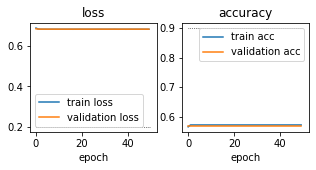

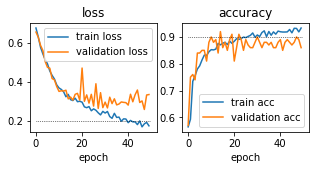

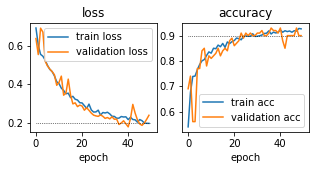

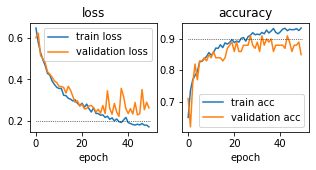

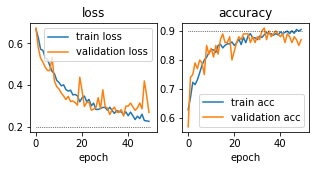

In [59]:
for t in range(T):
# for t in range(1,T-1):
    plot_mat2d(docume_tvla[t,:,:])

For T=6 the model did  not learn anything in 2 repetitions. The architecture completely failed 40% of the time!

For T=10 the model did not learn anything in 4 repetitions. The architecture completely failed 40% of the time!
That is bad but it can be avoided :-) by just starting again with another seed.

We continue to work with only the training validation loops / repetitions when the model did learn something.

In [60]:
# remove repetitions (of independent train val loops) when the model did not lern anything

print('before : ' , docume_error.shape)
if docume_error.shape[0]==T: 
    if T==5:
        # use only repetitions when the network did learn something
        docume_error = docume_error[1:,:,:]
        docume_tvla = docume_tvla[1:,:,:]
        docume_f1 = docume_f1[1:,:]
        docume_ge = docume_ge[1:,:,:,:]
        docume_ctl = docume_ctl[1:,:,:]
    elif T==10: # repetitions when model does not learn: 0,5,6,7
        docume_error = docume_error[(1,2,3,4,8,9),:,:] # this is not slicing?!
        docume_tvla = docume_tvla[(1,2,3,4,8,9),:,:]
        docume_f1 = docume_f1[(1,2,3,4,8,9),:]
        docume_ge = docume_ge[(1,2,3,4,8,9),:,:,:]
        docume_ctl = docume_ctl[(1,2,3,4,8,9),:,:]
else:
    print('check if repetitions have been removed correctly / before.')
print('after : ' , docume_error.shape)

before :  (5, 2, 50)
after :  (4, 2, 50)


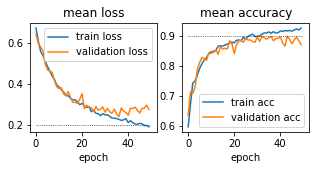

<Figure size 432x288 with 0 Axes>

In [61]:
plot_mat2d(docume_tvla.mean(axis=0), set_title=['mean loss', 'mean accuracy'])
plt.savefig(docume_dir_named+'loss_acc_mean.png')
plt.show()

## result from loss acc plots

### bias variance trade-off, early stopping

The mean of the training set accuracy (mean over the repetitions where the model actually does learn) rises to 90% after around 25 epochs, gets to almost 95% after 50 trining epochs. This indicates that the model can well differentiate b/w the given labels. There is no (heavy) bias problem.

The training loss continuously declines, which is good.

Since the validation (same mean as before) mean accuracy stays below 90% we have some variance remaining in our model / data set. The validation loss never reaches 0.2, it stops declining after about 30 epochs. 

The performance of this model is limited but not bad for my purpose.

The model should be trained around 25 to 30 epochs. After that overfitting starts.

In [62]:
est_early_stop_time = 40

# classification timeline
We first look into a single classification timeline, ctl is equal to docume_ctl[T-1,:,:], the ctl in the last repetition loop. ctl is a pandas DataFrame.

ctl is the classification timeline. The images in the validation set are the columns, each row contains information on how this image was classified in each epoch. ctl has num-epochs many rows

In [63]:
print('ctl.shape : ' , ctl.shape)
# print('ctl.columns : ' , list(ctl.columns)[0:5])
type(ctl)
print(ctl.shape)
ctl[0,:,:]

ctl.shape :  (100, 2, 50)
(100, 2, 50)


array([[777, 777, 777, 777, 777, 777, 777, 777, 777, 777, 777, 777, 777,
        777, 777, 777, 777, 777, 777, 777, 777, 777, 777, 777, 777, 777,
        777, 777, 777, 777, 777, 777, 777, 777, 777, 777, 777, 777, 777,
        777, 777, 777, 777, 777, 777, 777, 777, 777, 777, 777],
       [  1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int16)

We should add the info if in the end the classification is correct or not.

We already see that many classification timelines are constant.

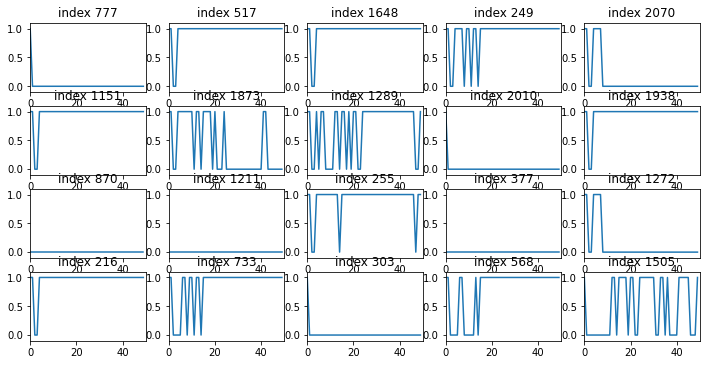

In [64]:
ctl=docume_ctl[1,:,:] # t=1 the independent repetition
# print(ctl.shape)
plt.figure(figsize=(12,15))
for i in range(20): # i ranges over the distinctive images , not the index
    #print(ctl[i,1,:]) # 1 is the classification data , 0 would be the index
    plt.subplot(10, 5, i+1)
    plt.axis((0,num_epochs,-0.1,1.1))
    plt.title('index {}'.format(ctl[i,0,0]))
    plt.plot(ctl[i,1,:])
    #ctl[ctl.columns[i]].plot()
# plt.savefig(docume_dir_named+'oscillation.png')

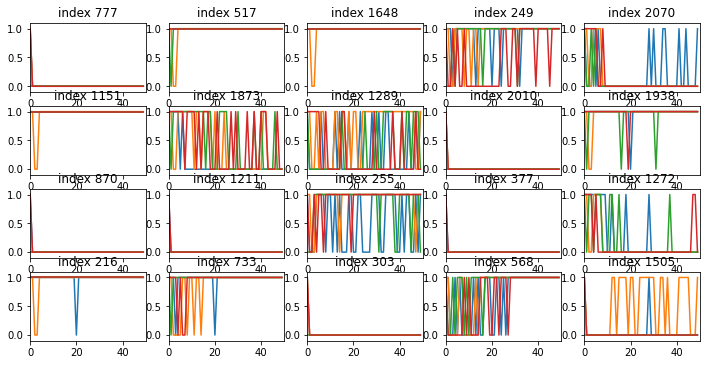

In [65]:
plt.figure(figsize=(12,15))
for i in range(20): # i ranges over the distinctive images , not the index
    #print(ctl[i,1,:]) # 1 is the classification data , 0 would be the index
    plt.subplot(10, 5, i+1)
    plt.axis((0,num_epochs,-0.1,1.1))
    plt.title('index {}'.format(docume_ctl[0,i,0,0]))
    plt.plot(docume_ctl[:,i,1,:].T)
    #ctl[ctl.columns[i]].plot()
# plt.savefig(docume_dir_named+'oscillation.png')

# check if they really belong together, if the index is constant for all the data that goes into a single plot. Know what I mean?

In [66]:
def count_changes(a):
    '''a a vector shape (1,n) or a matrix shape (m,n). Count for each row how often values change'''
    assert len(a.shape) ==2 , 'a should have 2 dimensions. You do the slicing, not me!'
    m,n = a.shape # if a has more than 2 dimensions, work with only the first 2 dimensions
    return [n-1-[a[j,k+1]-a[j,k] for k in range(n-1)].count(0) for j in range(m)]

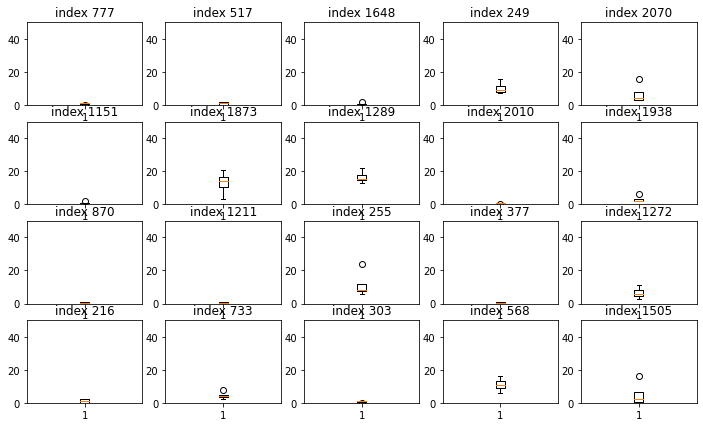

In [67]:
# transform 100 line plots into a bar chart
# for each line plot count the numbers of changes (about twice the number of peaks (2 changes = 1 peak or valley))

#create a pandas
df = pd.DataFrame(docume_ctl[0,:,0,0])
# visualize
plt.figure(figsize=(12,7))
for i in range(20):
    #a = docume_ctl[:,i,1,:] # 2 dim , flat,; row for repetiton, column for epoch
    plt.subplot(4, 5, i+1)
    #b=[num_epochs-1-[a[j,k+1]-a[j,k] for k in range(num_epochs-1)].count(0) for j in range(a.shape[0])]
    #print(b)
    plt.boxplot(count_changes(docume_ctl[:,i,1,:]))
    plt.axis((0,2,0,num_epochs))
    plt.title('index {}'.format(docume_ctl[0,i,0,0]))
plt.show()

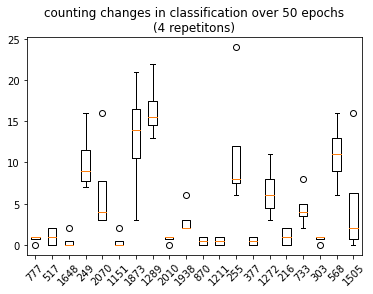

In [68]:
# create a pandas 
# create the index of rows , the index in the dataloader
df = pd.DataFrame({'index': docume_ctl[0,:,0,0]}).set_index('index')
# print(docume_ctl.shape)
#create columns, one for each repetition (Dont use T, because some repetitons were removed (algo did not learn))
for t in range(docume_ctl.shape[0]):
    df[str(t)]= 0

for i in range(docume_ctl.shape[1]): # loop through images (via their index, as in labels_i, labels['index'] returned by dataloader)
    df.iloc[i]= count_changes(docume_ctl[:,i,1,:])
#print(df.iloc[0:20])
# visualize

plt.title('counting changes in classification over {} epochs\n({} repetitons)'.format(num_epochs, docume_ctl.shape[0]))
plt.boxplot(df.iloc[0:20])
# draw index as xlabel
# plt.xticks([range(20)], docume_ctl[0,0:20,0,0], size='small')
plt.xticks(ticks=list(range(1,21)),labels=list(df.index[0:20]),rotation=45)
plt.savefig(docume_dir_named+'oscillation_{}repetitons_boxplot.png'.format(docume_ctl.shape[0]))
plt.show()

777 983.jpg
777
0    777
Name: 0, dtype: int16


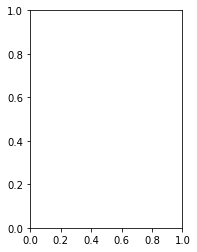

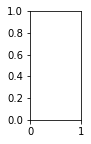

517 400.jpg
517
0    777
Name: 0, dtype: int16


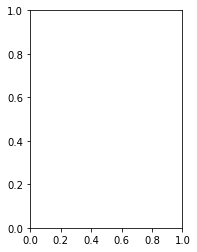

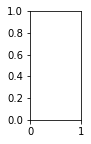

1648 2105.jpg
1648
0    777
Name: 0, dtype: int16


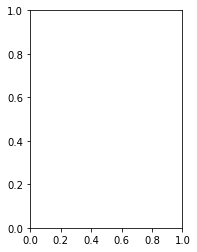

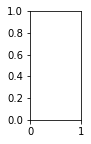

249 401.jpg
249
0    777
Name: 0, dtype: int16


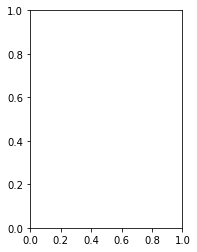

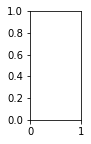

2070 1110.jpg
2070
0    777
Name: 0, dtype: int16


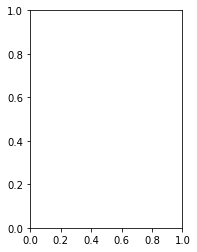

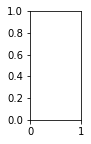

1151 217.jpg
1151
0    777
Name: 0, dtype: int16


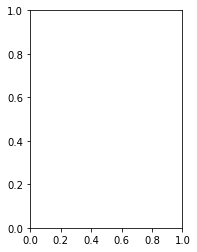

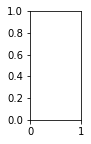

1873 586.jpg
1873
0    777
Name: 0, dtype: int16


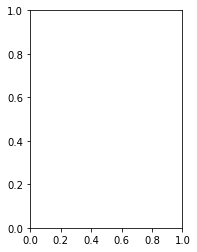

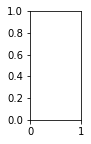

1289 833.jpg
1289
0    777
Name: 0, dtype: int16


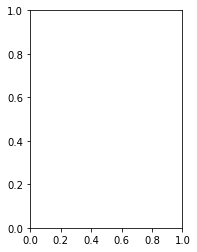

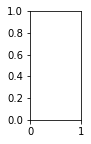

2010 282.jpg
2010
0    777
Name: 0, dtype: int16


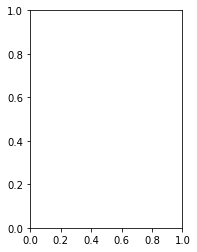

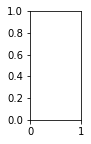

1938 912.jpg
1938
0    777
Name: 0, dtype: int16


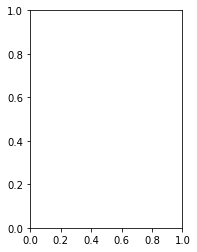

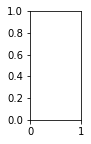

870 176.jpg
870
0    777
Name: 0, dtype: int16


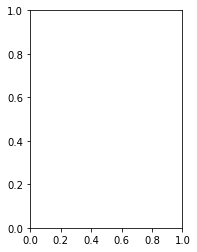

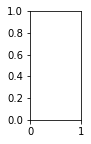

1211 1997.jpg
1211
0    777
Name: 0, dtype: int16


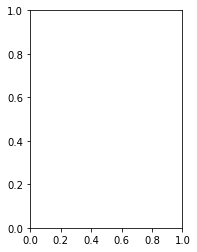

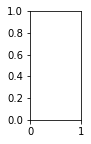

255 1016.jpg
255
0    777
Name: 0, dtype: int16


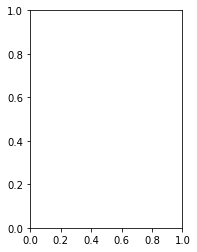

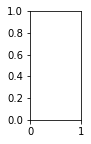

377 1585.jpg
377
0    777
Name: 0, dtype: int16


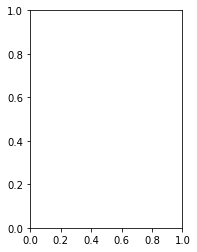

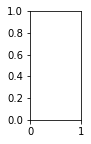

1272 816.jpg
1272
0    777
Name: 0, dtype: int16


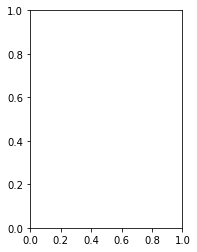

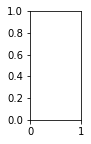

216 946.jpg
216
0    777
Name: 0, dtype: int16


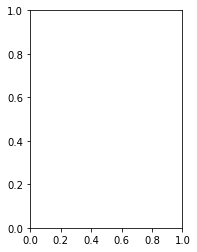

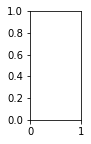

733 1357.jpg
733
0    777
Name: 0, dtype: int16


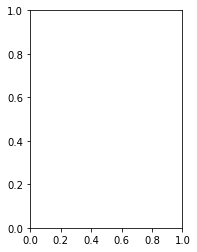

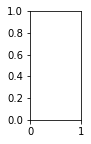

303 562.jpg
303
0    777
Name: 0, dtype: int16


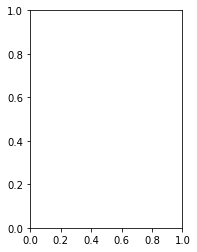

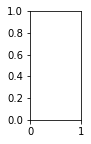

568 539.jpg
568
0    777
Name: 0, dtype: int16


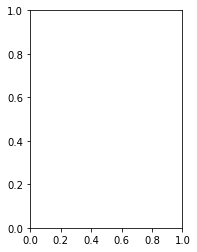

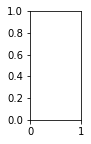

1505 187.jpg
1505
0    777
Name: 0, dtype: int16


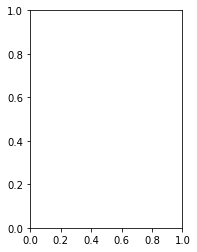

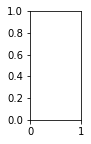

In [37]:
torch.no_grad():
    for img, lab in val_loader.dataset:
        print('the labels : ' , lab['index'],lab['file'], 'male' if lab['gender'] else 'female')
        # subplot 1 : the image
        plt.subplot(121)
        #plt.figure(figsize=(2, 2))
        plt.imshow(img.permute(1,2,0))
        plt.axis('off')
        # subplot 2 : the oscillation
        #print(lab['index'])
        #print(df.iloc[0])
        plt.subplot(122)
        plt.boxplot(list(df.loc[int(lab['index'])]))
        plt.axis((0,2,0,num_epochs))
        plt.show()

## classification timelines grouped by correct classification vs misclassification

In [39]:
# accessing information through the data loader
dict1 = {}
print(len(val_loader))
for img, lab in val_loader.dataset:
    dict1[lab['file']]=lab['gender']
g = pd.DataFrame.from_dict(dict1, orient='index', columns=['gender'])

10


I do not see a similarity in the images with no/1 or many oscillations. And I don't see a difference b/w the groups.

Now we should see, if the oscillation is concentrated on a subset of images or if it is randomly spread over the validation set.

We have to compare the number of oscillations over the repetitions. 

1. mean number of (highly) oscillating images per repetition.

2. sd of number of (highly) oscillating images per repetition

3. Statistical test: is there an underlying true number of (highly) oscillating images or is the number of (highly) oscillating images per repetition a random number.

4. Are there images that oscillate in many / all repetitions? Is the oscillation of an image a property / charcteristic or just random noise? Are there vulnerable images? Is vulnerability related to gender or ethnicity labels?

5. is vulnerability related to misclassification? Or independent thereof?

In [40]:
ctl.sum(axis=1) / len(val_loader.dataset) # proportion of classified male for the epochs
# first 5 (say...) epochs should be removed from analysis.

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64

In [21]:
ctl.sum(axis=1) / len(val_loader.dataset) # proportion of classified male for the epochs
# first 5 (say...) epochs should be removed from analysis.
ctl_after_wup = ctl.copy() # classification timeline after wup : warm up
wup_epochs = 5
ctl_after_wup = ctl[wup_epochs:]
print(ctl_after_wup.shape)

(45, 100)


pecm    0.092593
cese    0.000000
dtype: float64 pecm    0.936782
cese    1.000000
dtype: float64


,pecm,cese
983.jpg,0.000000,0
400.jpg,1.000000,1
2105.jpg,1.000000,1
401.jpg,0.866667,1
1110.jpg,0.133333,0
...,...,...
327.jpg,0.355556,0
421.jpg,0.555556,0
813.jpg,0.000000,0
1190.jpg,0.022222,0


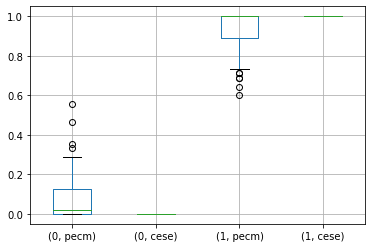

In [24]:
df = pd.DataFrame(ctl_after_wup.sum(axis=0) / ctl_after_wup.shape[0], columns=['pecm']) # proportion of epochs when classified male
df['cese'] = pd.DataFrame(ctl_after_wup.iloc[est_early_stop_time-wup_epochs]) # classification at estimated stopping epoch
print(df[df['cese']==0].mean() ,df[df['cese']==1].mean())
#print('mean :\n' , b.groupby('cese').mean(), '\nmedian :\n' , b.groupby('cese').median())
df.groupby('cese').boxplot('pecm')
df

In [25]:
df['gender'] = g
df['cese correct'] = (df['cese'] == df['gender']).astype(int)
df

,pecm,cese,gender,cese correct
983.jpg,0.000000,0,0,1
400.jpg,1.000000,1,1,1
2105.jpg,1.000000,1,1,1
401.jpg,0.866667,1,1,1
1110.jpg,0.133333,0,0,1
...,...,...,...,...
327.jpg,0.355556,0,0,1
421.jpg,0.555556,0,1,0
813.jpg,0.000000,0,0,1
1190.jpg,0.022222,0,0,1
